In [2]:
! pwd

/home/dc2484


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import pickle
import shap

In [4]:
def GridSearchRF(rank):

    # load dataset
    df = pd.read_csv('/work/hpc/users/dc2484/Machine_learning/feature_tbl_' + rank + '.csv')
    df = df.drop(df.columns[0], axis=1)

    print('Using feature table of rank: ' + str(rank))

    # split into input and output elements
    X, y = df.drop('Watering_Regm', axis=1), df['Watering_Regm']
    ft_list = X.columns

    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=4, shuffle=True, random_state=42)

    # performance reports
    accuracy_results = list()
    f1_results = list()
    precision_results = list()
    recall_results = list()

    # preparation for ROC curve
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))

    df = df.drop('Watering_Regm', axis = 1)
    enriched_all = pd.DataFrame(ft_list, columns = ['Taxa'])
    list_shap_values = list()
    list_test_sets = list()
    idx = 0


    for train_ix, test_ix in cv_outer.split(X):
        
    
        # split data
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        #print("X test length: ", len(X_test))
        #print("X test type: ", type(X_test))
        #print("X test shape: ", X_test.shape)
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

        # define the model
        model = RandomForestClassifier(random_state=42)

        # define search space
        space = dict()
        space['n_estimators'] = [100, 200, 500, 750, 1000, 1500, 2000]
        space['max_depth'] = [int(x) for x in np.linspace(10, 110, num = 11)]
        space['min_samples_leaf'] = [1, 2, 4]
        space['min_samples_split'] = [2, 5, 10]
        space['max_features'] = ['sqrt', 'log2']

        # define search
        search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        prec = precision_score(y_test, yhat)
        rec = recall_score(y_test, yhat)

        # store the result
        accuracy_results.append(acc)
        f1_results.append(f1)
        precision_results.append(prec)
        recall_results.append(rec)

        # save best estimator
        filename = '/work/hpc/users/dc2484/Machine_learning/RFC_{}_{}.sav'.format(idx+1, rank)
        pickle.dump(best_model, open(filename, 'wb'))

        # ROC curve
        best_model.fit(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            best_model,
            X_test,
            y_test,
            name=f"Best model {idx+1}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # SHAP values
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)
        list_shap_values.append(shap_values)
        list_test_sets.append(test_ix)
        shap_obj = explainer(X_test)

        high_index = pd.DataFrame(shap_obj.data, columns=shap_obj.feature_names, index=X_test.index).idxmax()
        #shap_val_2d = shap_values.reshape(-1, shap_values.shape[-1])
        shap_values_reduced = shap_values[:, :, 1]  # Selecting SHAP values for class 1

        for val in list_shap_values: # prints the length of the individual shap values (shap values are returned by function as an array)
            print("List of individual shap values length: ", len(val))

        #print("Shap values 2d shape: ", shap_val_2d.shape)
        #print("Shap values 2d full: ", shap_val_2d)
        #print("Shap obj feature names: ", shap_obj.feature_names)
        #print("Shap obj feature names shape: ", shap_obj.shape)
        
        #print("Shap values[1]: ", shap_values[1])
        #print("Shap values full: ", shap_values)
        print("X Index.index: ", X_test.index)
        print("X Index.shape: ", X_test.shape)
        #print("X test: ", X_test)
        
        shap_drought = pd.DataFrame(shap_values_reduced, columns=shap_obj.feature_names, index=X_test.index) 
        enriched = list()
        for v, i in high_index.items():
            sv = shap_drought[v].loc[i]
            if sv<0:
                sv = "Control"
            else:
                sv = "Drought"
            enriched.append(
                {
                    'Taxa': v,
                    'enriched': sv
                }
            )
        enriched = pd.DataFrame(enriched)
        enriched.rename(columns={'enriched': 'enriched{}'.format(idx+1)}, inplace=True)
        enriched_all = enriched_all.merge(enriched, on='Taxa', how='outer')

        idx += 1

    # continue ROC
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve on {rank} rank",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    #plt.show()

    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(1,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)

    #bringing back variable names    
    X_test = pd.DataFrame(X.iloc[test_set])
    X_test.columns = ft_list
    
    #creating explanation plot for the whole experiment
    #shap.summary_plot(shap_values[1], X_test)
    enriched_all.to_csv('/work/hpc/users/dc2484/Machine_learning/SHAP_enriched_' + rank + '.csv', index=False)

    # SHAP feature importances
    mean_shap_feature_values = pd.DataFrame(shap_values_reduced, columns=ft_list).abs().mean(axis=0).sort_values(ascending=False)
    mean_shap_feature_values.index.name = 'features'
    mean_shap_feature_values.name = 'mean_shap'
    mean_shap_feature_values = mean_shap_feature_values.reset_index()
    mean_shap_feature_values.to_csv('/work/hpc/users/dc2484/Machine_learning/SHAP_feature_importance_' + rank + '.csv', index=False)

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f), F1: %.3f (%.3f), Precision: %.3f (%.3f), Recall: %.3f (%.3f)' % (np.mean(accuracy_results), np.std(accuracy_results), np.mean(f1_results), np.std(f1_results), np.mean(precision_results), np.std(precision_results), np.mean(recall_results), np.std(recall_results)))

Using feature table of rank: genus
List of individual shap values length:  16
X Index.index:  Index([0, 5, 9, 12, 13, 16, 25, 34, 36, 40, 44, 50, 52, 56, 58, 61], dtype='int64')
X Index.shape:  (16, 309)
List of individual shap values length:  16
List of individual shap values length:  16
X Index.index:  Index([3, 4, 6, 8, 17, 19, 30, 31, 33, 41, 47, 49, 54, 55, 59, 60], dtype='int64')
X Index.shape:  (16, 309)


/work/hpc/users/dc2484/Virtual_environments/miniconda3/envs/machine_learning/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


List of individual shap values length:  16
List of individual shap values length:  16
List of individual shap values length:  16
X Index.index:  Index([1, 2, 11, 15, 21, 24, 26, 27, 29, 32, 37, 43, 45, 46, 48, 57], dtype='int64')
X Index.shape:  (16, 309)


/work/hpc/users/dc2484/Virtual_environments/miniconda3/envs/machine_learning/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


List of individual shap values length:  16
List of individual shap values length:  16
List of individual shap values length:  16
List of individual shap values length:  16
X Index.index:  Index([7, 10, 14, 18, 20, 22, 23, 28, 35, 38, 39, 42, 51, 53, 62, 63], dtype='int64')
X Index.shape:  (16, 309)
Accuracy: 0.812 (0.159), F1: 0.819 (0.136), Precision: 0.827 (0.145), Recall: 0.814 (0.132)


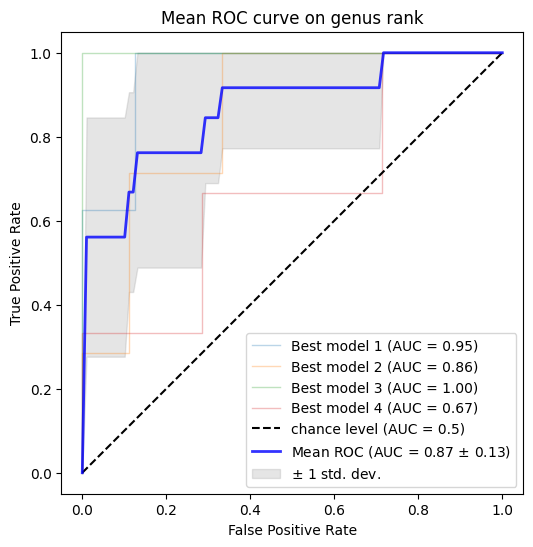

In [5]:
GridSearchRF('genus')